In [2]:
from collections import defaultdict
from importlib import reload
from itertools import product
from pathlib import Path
from time import perf_counter

import sys
sys.path.append("../src")
import convex
import frank_wolfe
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm


[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

In [3]:
df = pd.read_csv('../../data/mimic-los-data.csv')

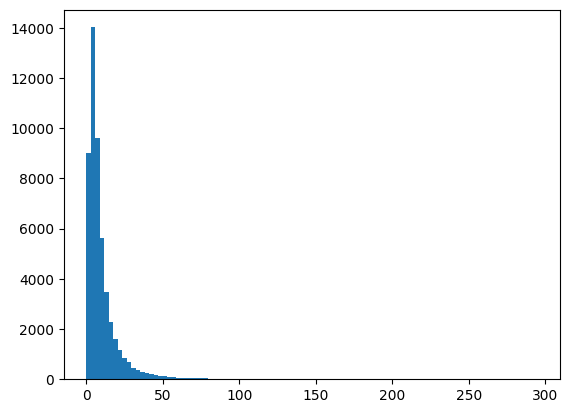

In [8]:
plt.hist(df.LOS, bins=100);

In [10]:
df.LOS[:20]

0      1.144444
1      5.496528
2      6.768056
3      2.856944
4      3.534028
5      6.988889
6      2.686806
7      5.364583
8     19.197917
9      3.565972
10    10.177083
11     8.281250
12    12.736806
13    10.073611
14     5.087500
15    25.459722
16     9.754167
17    27.218750
18    28.282639
19    85.420833
Name: LOS, dtype: float64

In [9]:
def get_error(x_b, y_b, x_s, y_s, w, k=10):
    s = w.argsort()[::-1][:k]
    x_k = x_s[s]
    y_k = y_s[s]
    beta_k = np.linalg.pinv(x_k) @ y_k
    y_hat = x_b @ beta_k

    # LR = LinearRegression(fit_intercept=False)
    # LR.fit(x_k, y_k)
    # y_hat = LR.predict(x_b)
    return mean_squared_error(y_b, y_hat)

In [451]:
reload(utils)
data = utils.get_data(
    # dataset="gaussian",
    # dataset="news",
    # dataset="mimic",
    dataset="bone-clip",
    num_buyer=30,
    num_seller=5000,
    num_val=100,
    dim=100,
    noise_level=0.1,
)

x_s = data["X_sell"].astype(np.single)
y_s = data["y_sell"]
x_val = data["X_val"].astype(np.single)
y_val = data["y_val"]
x_b = data["X_buy"].astype(np.single)
# coef = data.get("coef")
# y_b = (data["X_buy"] @ coef) if coef is not None else data["y_buy"]
y_b = data["y_buy"]

In [459]:
e = 0.1 * np.random.randn(y_s.shape[0])

(array([   3.,   21.,  169.,  603., 1282., 1551.,  971.,  321.,   70.,
           9.]),
 array([-5.96588339, -4.8329863 , -3.70008922, -2.56719213, -1.43429504,
        -0.30139796,  0.83149913,  1.96439621,  3.0972933 ,  4.23019039,
         5.36308747]),
 <BarContainer object of 10 artists>)

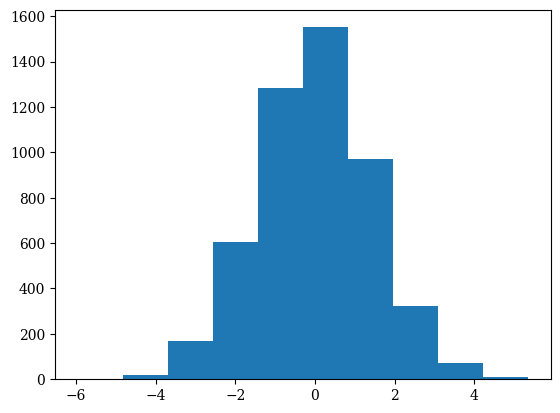

In [481]:
d = y_s.mean() * (e / 9)
plt.hist(d)

(array([  65.,  200.,  321.,  415.,  626.,  902., 1203.,  935.,  289.,
          44.]),
 array([  1. ,  23.7,  46.4,  69.1,  91.8, 114.5, 137.2, 159.9, 182.6,
        205.3, 228. ]),
 <BarContainer object of 10 artists>)

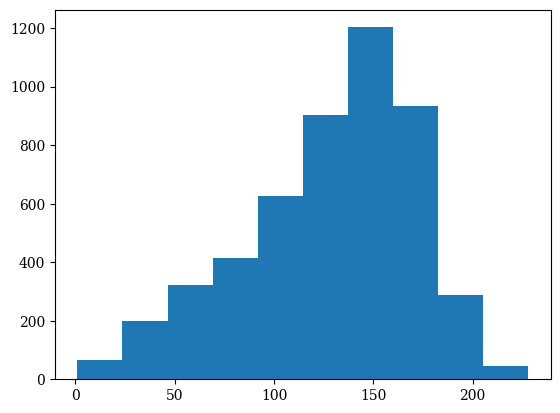

In [471]:
plt.hist(y_s)

In [469]:
d.min()

-53.69295049342468

In [ ]:
reload(frank_wolfe)
rang = list(range(2, 30, 2)) + list(range(20, 250, 5))

errors = defaultdict(list)

for j in range(0, x_b.shape[0]):
    x_test = x_b[j : j + 1]
    y_test = y_b[j : j + 1]

    w_os = frank_wolfe.one_step(x_s, x_test)
    res_fw = main_gaussian.design_selection(
        (x_s, y_s),
        (x_test, y_test),
        num_select=10,
        num_iters=500,
        alpha=0.1,
        recompute_interval=0,
        line_search=True,
    )
    w_fw = res_fw["weights"]
    errors['Ours (multi-step)'].append([get_error(x_test, y_test, x_s, y_s, w_fw, k) for k in rang])
    errors['Ours (single step)'].append([get_error(x_test, y_test, x_s, y_s, w_os, k) for k in rang])


    w_baselines = main_gaussian.get_baseline_values(
        x_s, y_s, x_val, y_val, np.ones_like(x_val), np.ones_like(y_val), 
        baselines=[
            "DataOob",
            'KNNShapley',
            'LavaEvaluator',
            'RandomEvaluator',
            'DVRL',
            # 'InfluenceSubsample',
            # 'DataBanzhaf',
            # 'DataShapley',
            # 'LeaveOneOut',
            # 'BetaShapley',
        ],
        baseline_kwargs={
            'DataOob': {'num_models': 100},
            'KNNShapley': {},
            'LavaEvaluator': {},
            'DVRL': {'rl_epochs': 100},
            'InfluenceSubsample': {'samples': 100},
            'DataBanzhaf': {'num_models': 100, 'models_per_epoch': 10},
            'DataShapley': {'min_models': 100, 'models_per_epoch': 10},
            'BetaShapley': {'min_models': 100, 'models_per_epoch': 10},
            'LeaveOneOut': {},
        },
    )[0]

    for k, v in w_baselines.items():
        errors[k].append([get_error(x_test, y_test, x_s, y_s, v, k) for k in rang])

    # w_cvx = V.optimize(x_test, x_s)
    # err_cvx.append([get_error(x_test, y_test, x_s, y_s, w_cvx, k) for k in rang])

    w_rand = np.random.permutation(len(x_s))
    errors['Random'].append([get_error(x_test, y_test, x_s, y_s, w_rand, k) for k in rang])
    print(f'round {j} done')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 89.56it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]


	TIME: 30
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 2993.87it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 10
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.09it/s]


	TIME: 13
round 0 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 70.50it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


	TIME: 28
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 4001.10it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 8
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 121.74it/s]


	TIME: 12
round 1 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 110.57it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.52it/s]


	TIME: 29
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:02<00:00, 2447.46it/s]


	TIME: 3
-------------LavaEvaluator--------------


	TIME: 4
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.85it/s]


	TIME: 12
round 2 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 125.02it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


	TIME: 29
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 2750.06it/s]


	TIME: 3
-------------LavaEvaluator--------------


	TIME: 4
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.97it/s]


	TIME: 21
round 3 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 125.30it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


	TIME: 29
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 5761.98it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 8
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.22it/s]


	TIME: 10
round 4 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.63it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


	TIME: 29
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 2712.39it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 1
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.80it/s]


	TIME: 18
round 5 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 147.87it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


	TIME: 30
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:02<00:00, 2412.73it/s]


	TIME: 3
-------------LavaEvaluator--------------


	TIME: 4
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.24it/s]


	TIME: 28
round 6 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 133.76it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


	TIME: 28
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 3905.82it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 3
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.72it/s]


	TIME: 9
round 7 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 125.06it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]


	TIME: 29
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 5881.00it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 5
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.01it/s]


	TIME: 5
round 8 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 134.80it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


	TIME: 28
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 5599.79it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 8
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.59it/s]


	TIME: 6
round 9 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 144.70it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s]


	TIME: 28
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 5544.64it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 2
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.06it/s]


	TIME: 23
round 10 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 150.02it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.57it/s]


	TIME: 29
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 2878.01it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 7
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.81it/s]


	TIME: 15
round 11 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 124.77it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


	TIME: 31
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 5106.20it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 6
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.93it/s]


	TIME: 9
round 12 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 139.82it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


	TIME: 31
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 3223.23it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 1
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.30it/s]


	TIME: 6
round 13 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 127.27it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


	TIME: 28
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 2706.73it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 11
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.00it/s]


	TIME: 13
round 14 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 147.48it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


	TIME: 28
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 2794.09it/s]


	TIME: 3
-------------LavaEvaluator--------------


	TIME: 5
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.69it/s]


	TIME: 17
round 15 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.27it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


	TIME: 30
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 4092.58it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 6
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.97it/s]


	TIME: 18
round 16 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 87.01it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


	TIME: 37
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 4662.15it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 4
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.67it/s]


	TIME: 13
round 17 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 97.02it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


	TIME: 37
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 4474.19it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 6
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.07it/s]


	TIME: 3
round 18 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 76.24it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


	TIME: 30
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 2633.61it/s]


	TIME: 3
-------------LavaEvaluator--------------


	TIME: 3
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.56it/s]


	TIME: 7
round 19 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 140.04it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.06it/s]


	TIME: 25
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 3601.79it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 7
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.34it/s]


	TIME: 15
round 20 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 118.77it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


	TIME: 27
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 4645.77it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 11
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.18it/s]


	TIME: 18
round 21 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.55it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


	TIME: 29
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 3114.47it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 6
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.58it/s]


	TIME: 25
round 22 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 67.63it/s]


----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


	TIME: 31
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 2727.75it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 10
------------RandomEvaluator-------------
	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.37it/s]


	TIME: 22
round 23 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 98.77it/s]


----------------DataOob-----------------


 38%|██████████████████████████████████████████████████████▋                                                                                         | 38/100 [00:09<00:14,  4.37it/s]

In [ ]:
figure_dir = Path('../figures')

In [399]:
l = []
for k, v in errors.items():
    l.append(np.array(v).mean())
    l.append(np.quantile(v, 0.9))
    

(1790.615705096439, 441.2689592856558)

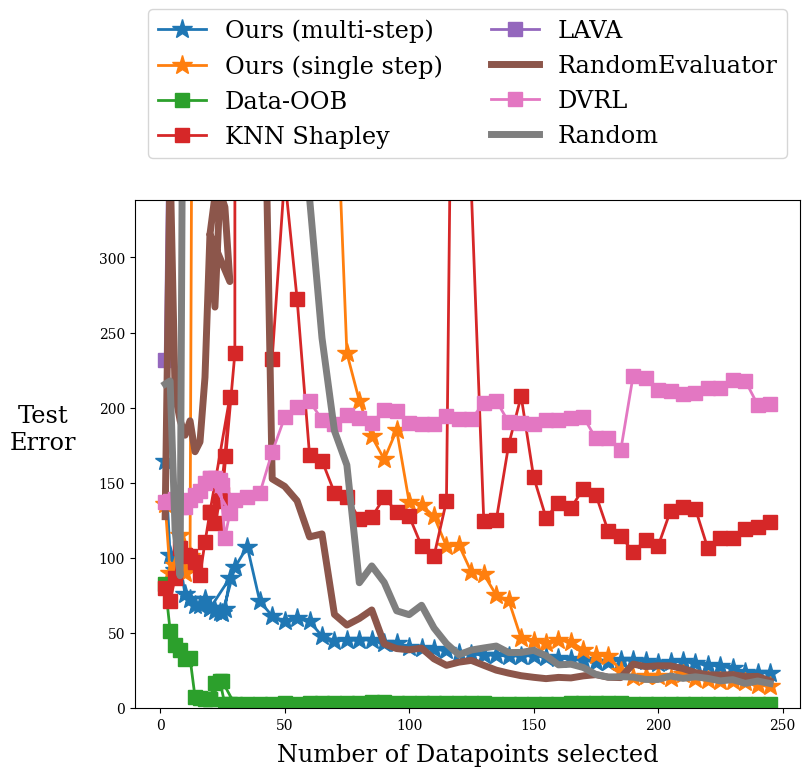

In [400]:
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(8, 8))

quantiles = []
for k, v in errors.items():
    err = np.array(v)
    quantiles.append(np.quantile(err, 0.9))
    ms = 10
    match k:
        case 'LavaEvaluator':
            k = 'LAVA'
        case 'InfluenceSubsample':
            k = 'Influence'
        case 'LeaveOneOut':
            k = 'Leave One Out'
        case 'KNNShapley':
            k = 'KNN Shapley'
        case 'DataOob':
            k = 'Data-OOB'
    match k:
        case k if 'Ours' in k:
            lw = 2
            ls = '-'
            marker = '*'
            ms = ms + 5
        case k if 'random' in k.lower():
            lw = 5
            ls = '-'
            marker = ''
        case _:
            lw = 2
            ls = '-'
            marker = 's'
    plt.plot(rang, err.mean(0).squeeze(), label=k, marker=marker, ls=ls, lw=lw, ms=ms)
    
# plt.xticks(np.arange(2, 21, 2), fontsize='x-large')
# plt.yticks(np.arange(0, 10, 0.5), fontsize='x-large')
# plt.xlim(1.5, 21)
# plt.ylim(0, 2.8)
    
# plt.xlim(1.5, 8)
plt.ylim(0, np.median(quantiles))
# plt.ylim(0, 1.3)
# plt.ylim(0, 0.3)
plt.xlabel('Number of Datapoints selected', fontsize='xx-large', labelpad=8)
plt.ylabel('Test\nError', fontsize='xx-large', rotation=0, labelpad=40)
plt.legend(fontsize='xx-large', bbox_to_anchor=(0.5, 1.4), loc='upper center', ncols=2)
# plt.legend(fontsize='x-large', loc='upper right')
plt.tight_layout(pad=0, w_pad=0)
# plt.savefig(figure_dir / f"overfitting-low-val.eps", bbox_inches="tight")

Text(0, 0.5, 'Prediction Error')

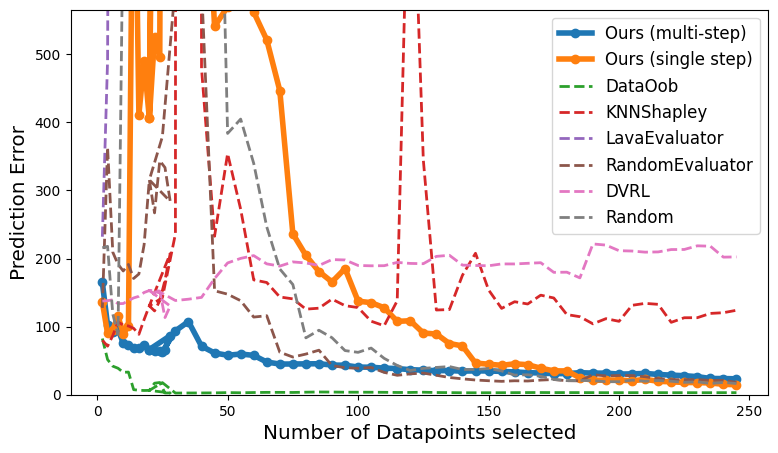

In [387]:
plt.figure(figsize=(9, 5))
for k, v in errors.items():
    err = np.array(v).mean(0).squeeze()
    marker = 'o' if 'Ours' in k else None
    ls = '-' if 'Ours' in k else '--'
    lw = 4 if 'Ours' in k else 2
    plt.plot(rang, err, label=k, marker=marker, ls=ls, lw=lw)
# plt.xlim(0, 100)
plt.ylim(0, 2*np.median(l))
# plt.ylim(0, 100)
# plt.yticks(np.arange(0, 2.1, 0.5))
plt.legend(fontsize='large')
plt.xlabel('Number of Datapoints selected', fontsize='x-large')
plt.ylabel('Prediction Error', fontsize='x-large')
# plt.savefig(figure_dir / f"baseline-compare-bone.eps", bbox_inches="tight")

In [16]:
pwd

'/u/luchar/data-markets/nbs'

In [12]:
from sklearn.datasets import make_regression

In [84]:
x, y, b = make_regression(n_samples = 100, n_features=1, noise=50, coef=True, bias=True, tail_strength=29)

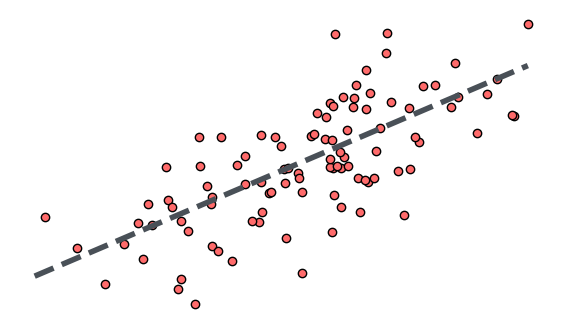

In [93]:
fig, ax = plt.subplots(figsize=(7, 4))
# your plotting code here, replace plt with ax for plot commands

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Optionally, you can also move the bottom and left spines
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_position(('outward', 10))

x_min = x.min() - 0.1
x_max = x.max() + 0.1
y_min = y.min() - 10
y_max = y.max() + 10

ax.scatter(x, y, c='#ff6b6b', edgecolor='k')
r = np.arange(x_min, x_max)
ax.plot(r, r * b, c='#495057', lw=4, ls='--')
# ax.arrow(x_min, y_min, 0., abs(y_min) + y_max + 0.1, fc='k', ec='k', lw = 2, 
#          head_width=0.2, head_length=6, overhang = 4, 
#          length_includes_head= False, clip_on = True)
# ax.arrow(x_min, y_min, abs(x_min) + x_max + 0.1, 0, fc='k', ec='k', lw = 2, 
#          head_width=25, head_length=0.05, overhang = 4, 
#          length_includes_head= False, clip_on = True)

ax.set_xticklabels([])
ax.set_yticklabels([])


plt.savefig(figure_dir / f"regression.png", bbox_inches="tight", dpi=500)



In [41]:
import uuid
from datetime import datetime

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H%M%S")

# Generate a random UUID
random_uuid = uuid.uuid4()

# Concatenate timestamp and UUID
human_readable_uuid = f"{timestamp}-{random_uuid}"

print(human_readable_uuid)


2024-01-27-232919-2b99b67f-3510-46cb-a87e-eb7f61c6169e


In [302]:
import pickle 

In [305]:
with open('../results/2024-01-17-021938-4dd5eef3-8817-4834-99d9-c491acd6dcf0-data.pkl', 'rb') as f:
    res = pickle.load(f)

In [ ]:
res['X_sell'].shape

In [314]:
import json
json.dumps(dict(errors))

'{"Ours (multi-step)": [[1676.876021594395, 6329.662210361595, 7824.343889231158, 4115.330114091098, 3381.0201896060794, 3585.822544142135, 5811.203588180038, 7582.32614953995, 7656.617115447818, 8342.968538685402, 6632.253516747381, 6992.841343892945, 6863.264905891647, 5417.228332613403, 8342.968538685402, 7072.770761552563, 5616.061796227386, 4802.092464194233, 7413.657578657398, 6131.426161279152, 4535.4336738105285, 4755.433653690588, 4695.758530168896, 5560.06479986683, 5750.093497940013, 3704.967913727332, 4322.797183784785, 2074.015869166348, 1462.9822383001099, 1698.5614271197462, 2389.0077239081097, 2404.3368557358012, 2614.723209963688, 3731.6606344292477, 3523.806310046411, 2350.1056426296736, 1986.798932071955, 1607.0930088162315, 1989.3873913082273, 1729.8508355130962]], "Ours (single step)": [[23.047437341406166, 730.8008358045057, 761.8226537179647, 864.454328656785, 5704.302879591556, 7746.571557813488, 4925.3347326166495, 4762.518240892113, 6516.692955739871, 6438.598

In [443]:
import pandas as pd

df = pd.read_csv('../../data/mimic-los-data.csv')

In [450]:
df.iloc[:, 1:]

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,...,AGE_newborn,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51032,0.0,4.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,1
51033,1.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
51034,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
51035,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0


In [444]:
df.describe()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,AGE_newborn,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
count,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,...,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000,51037.000000
mean,10.228510,0.370711,2.260007,0.077121,0.617591,1.175030,0.503968,0.308502,2.362698,0.428963,...,0.157572,0.533103,0.079060,0.056136,0.000294,0.412916,0.010052,0.232929,0.188726,0.098948
std,12.461440,0.652278,2.255679,0.357821,1.119265,1.345073,0.845481,0.670549,2.206709,0.856638,...,0.364343,0.498908,0.269835,0.230186,0.017141,0.492363,0.099753,0.422702,0.391295,0.298595
min,0.014583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.857639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.583333,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.805556,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,0.000000,3.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,294.660417,6.000000,16.000000,11.000000,11.000000,12.000000,7.000000,7.000000,23.000000,11.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [333]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [336]:
coef = np.linalg.inv(X.T @ X) @ X.T @ y

In [340]:
coef = np.linalg.pinv(X) @ y

In [341]:
coef

array([ 0.37349187,  0.35307375,  2.44637181,  1.45949062, -0.44800229,
        0.76477269,  2.64512788,  0.40962142, -0.83765889,  0.3621033 ,
       -0.29187969,  0.41700249,  0.60761536,  0.6521478 ,  4.68812506,
        2.22083762,  1.52738782, -0.05364421,  1.11154025,  1.16829949,
        0.23761678, -0.37843023, -1.42209151,  2.5102152 ,  0.55434957,
        0.81907317, -0.3899156 ,  0.41051925, -0.44671614, -0.1085008 ,
        0.61148411,  0.44432694,  0.48834378, -0.30560365, -0.26356897,
        1.01522241,  0.01291668,  1.60277008, -3.67629683,  1.2995765 ,
        1.7212605 ,  0.3840988 , -2.5912437 ,  0.46086459,  0.89125835,
        0.42215041,  0.98976719,  0.3904146 ])

In [337]:
coef

0     7.167443e+02
1    -5.933548e+01
2    -3.930309e+02
3    -8.022081e+01
4    -5.210111e+01
5     5.241070e+01
6    -8.260779e+02
7    -2.047594e+01
8    -1.288308e+02
9    -1.131949e+01
10   -2.781246e+01
11   -3.376861e+01
12   -2.432765e+01
13   -1.067105e+02
14    1.485847e+01
15   -3.323020e+01
16    1.693693e+01
17    1.315505e+02
18    5.819162e+02
19    2.030509e+03
20   -2.259743e+16
21   -2.259743e+16
22   -2.259743e+16
23   -2.259743e+16
24    1.762907e+16
25    1.762907e+16
26    1.762907e+16
27    1.762907e+16
28    1.762907e+16
29    2.515612e+17
30    2.515612e+17
31    2.515612e+17
32   -2.543382e+17
33   -2.543382e+17
34   -2.543382e+17
35   -2.543382e+17
36   -2.543382e+17
37    7.745288e+15
38    7.745288e+15
39    7.745288e+15
40    7.745288e+15
41   -9.230579e+00
42    1.355726e+02
43    1.119922e+01
44    6.578964e+01
45    5.097494e+01
46    5.890274e+01
47   -3.658687e+01
dtype: float64

In [326]:
cor = df.corr()

In [402]:
import torch 
x = torch.load('../../data/bone-age/bone_age_embeddings.pt')

In [404]:
x['embeddings'].shape

(12611, 512)

In [408]:
def apply_cost_func(x_sell, y_sell, beta_true, h, noise_level=0.1):
    x_sell = np.einsum('i,ij->ij', h(costs, a=0.5), x_sell)
    y_sell = x_sell @ beta_true + noise_level * np.random.randn(x_sell.shape[0])

def h(c, a=1, b=0): return c**a + b

# Implment with decorators
# @decorator
# linear_cost_func = func(a=1, b=0)

# @decorator
# squared_cost_func = func(a=2, b=0)

# @decorator
# squared_root_cost_func = func(a=0.5, b=0)

(5000, 48)

In [488]:

df = pd.read_csv('../../data/fitzpatrick17k/fitzpatrick17k.csv')

In [490]:
missing = open('../../data/fitzpatrick17k/missing.txt', 'r').read().split('\n')
df['exclude'] = df.apply(lambda r: True if r.md5hash in missing else False, axis=1)
df = df[~df.exclude]

df['aggregated_fitzpatrick_scale'] = df.apply(lambda r: r.fitzpatrick_centaur if r.fitzpatrick_scale == -1 and r.fitzpatrick_centaur != -1 else r.fitzpatrick_scale, axis=1)
df['aggregated_fitzpatrick_scale'] = df.apply(lambda r: (r.aggregated_fitzpatrick_scale + r.fitzpatrick_centaur) / 2 if r.aggregated_fitzpatrick_scale != -1 and r.fitzpatrick_centaur != -1 else r.aggregated_fitzpatrick_scale, axis=1)
# df['aggregated_fitzpatrick_scale'] = df.aggregated_fitzpatrick_scale.round()


/tmp/ipykernel_15442/1841423174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aggregated_fitzpatrick_scale'] = df.apply(lambda r: r.fitzpatrick_centaur if r.fitzpatrick_scale == -1 and r.fitzpatrick_centaur != -1 else r.fitzpatrick_scale, axis=1)
/tmp/ipykernel_15442/1841423174.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aggregated_fitzpatrick_scale'] = df.apply(lambda r: (r.aggregated_fitzpatrick_scale + r.fitzpatrick_centaur) / 2 if r.aggregated_fitzpatrick_scale != -1 and r.fitzpatr

In [496]:
df.columns

Index(['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label',
       'nine_partition_label', 'three_partition_label', 'qc', 'url',
       'url_alphanum', 'exclude', 'aggregated_fitzpatrick_scale'],
      dtype='object')

In [511]:
df.to_csv('../../data/fitzpatrick17k/fitzpatrick-mod.csv')

In [507]:
img_dir = Path('../../data/fitzpatrick17k/images')

In [523]:
list(img_dir.iterdir())[0].stem in df.md5hash.values

True

In [528]:
df[df.md5hash == list(img_dir.iterdir())[0].stem].aggregated_fitzpatrick_scale.values[0]

1.5

In [535]:
def get_fitzpatrick_data(
    num_samples,
    data_dir,
    img_dir="fitzpatrick17k/images",
    csv_path="fitzpatrick17k/fitzpatrick-mod.csv",
    recompute_embeddings=False,
    embedding_path="fitzpatrick17k/fitzpatrick_embeddings.pt",
    device="cuda",
    model_name="clip",
):
    data_dir = Path(data_dir)
    embedding_path = Path(embedding_path)
    embedding_name = f"{embedding_path.stem}_{model_name}{embedding_path.suffix}"
    embedding_path = embedding_path.parent / embedding_name
    if recompute_embeddings or not (data_dir / embedding_path).exists():
        print(f'No embeddings found at: {data_dir / embedding_path}. Creating new embeddings...')
        img_dict = {p.stem: p for p in Path(data_dir / img_dir).glob("*.jpg")}
        df = pd.read_csv(data_dir / csv_path)
        img_paths = []
        labels = []
        for k, v in img_dict.items():
            if k in df.md5hash.values:
                img_paths.append(v)
                labels.append(df[df.md5hash == k].aggregated_fitzpatrick_scale.values[0])
        embeddings = utils.embed_images(img_paths, device=device, model_name=model_name).numpy()
        labels = torch.tensor(labels).numpy()
        torch.save(
            dict(embeddings=embeddings, labels=labels), data_dir / embedding_path
        )

    embed_dict = torch.load(data_dir / embedding_path)
    embeddings = embed_dict["embeddings"]
    labels = embed_dict["labels"]

    return dict(X=embeddings[:num_samples], y=labels[:num_samples])

In [536]:
x = get_fitzpatrick_data(10, '../../data')

No embeddings found at: ../../data/fitzpatrick17k/fitzpatrick_embeddings_clip.pt. Creating new embeddings...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16527/16527 [40:53<00:00,  6.74it/s]


In [540]:
df.shape

(16536, 11)

In [2]:
from pathlib import Path
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torchvision.transforms as transforms
import torch
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from torch.utils.data import DataLoader

In [6]:
train_df = pd.read_csv(Path('../../data/druglib/drugLibTrain_raw.tsv'), sep='\t')
test_df = pd.read_csv(Path('../../data/druglib/drugLibTest_raw.tsv'), sep='\t')


In [7]:
df = pd.concat([train_df, test_df])

In [9]:
df.to_csv('../../data/druglib/druglib.csv', index=False)

In [94]:
df = pd.read_csv('../../data/druglib/druglib.csv')

In [95]:
df

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...,...
4138,690,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...
4139,1071,proair-hfa,10,Highly Effective,No Side Effects,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...
4140,681,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ..."
4141,2709,divigel,10,Highly Effective,No Side Effects,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...


In [5]:
#utilize GPT2 pretrained model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained('gpt2').to('cuda')

def generate_embeddings(sentence, max_length=4096, device='cuda'):
    inputs = tokenizer(sentence, return_tensors="pt", max_length=max_length, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_embedding = outputs.last_hidden_state.mean(dim=1).cpu()
    return sentence_embedding

In [6]:
# len(df.iloc[936].commentsReview)

In [14]:
from tqdm.notebook import tqdm 

xs = []
ys = []
for i, r in tqdm(df.iterrows()):
    review = f'Benefits: {r.benefitsReview}\nSide effects: {r.sideEffectsReview}\nComments: {r.commentsReview}'
    if len(review) > 4096: 
        print(len(review))
        continue
    x = generate_embeddings(review, device='cuda')
    xs.append(x)
    ys.append(r.rating)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [16]:
df.shape

(4143, 9)

In [9]:
X.shape

torch.Size([4142, 768])

In [12]:
r.rating

8